In [13]:
# let's try using linear regression to predict the label using the irregularity score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a support vector classifier
from sklearn.svm import SVC

# Create a Bayesian optimization
from bayes_opt import BayesianOptimization

# visualize using pairplot
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# load the results
arima_results = pd.read_csv('data/arima_results.csv')
arima_results = arima_results.dropna().drop('record_id', axis=1)
print('results shape:', arima_results.shape)

results shape: (191, 4)


In [43]:
# lets print the columns
print(arima_results.columns)

Index(['label', 'irregularity_score', 'adf_statistic', 'adf_pvalue'], dtype='object')


In [44]:
# adf_statistics and adf_pvalues are not useful
results = arima_results.drop(columns=['adf_statistic', 'adf_pvalue'])
print(results.columns)


Index(['label', 'irregularity_score'], dtype='object')


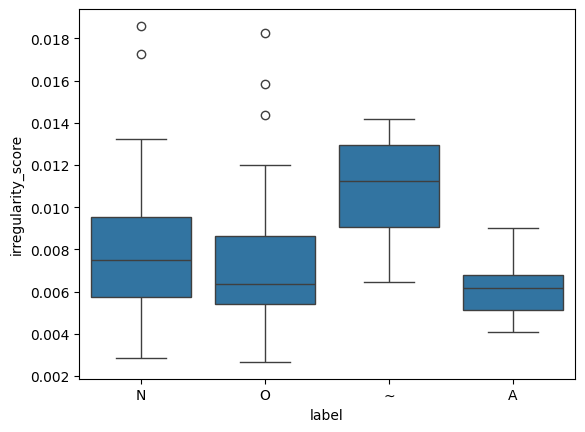

In [45]:
# plot the irregularity score per label
sns.boxplot(x='label', y='irregularity_score', data=arima_results)
plt.show()


### Irregularity Score

Based on the boxplot, we can detect "Noise" (~) as its range  is far from Normal.  However, "Afib"(A) and "Others"(O) falls within the range of Normal (N).  Therefore, we can use this metric only for detecting "Others".

In [30]:
# load the results
hrv_results = pd.read_csv('data/hrv_results.csv')
hrv_results = hrv_results.dropna().drop('record_id', axis=1)
print('results shape:', hrv_results.shape)

results shape: (8004, 15)


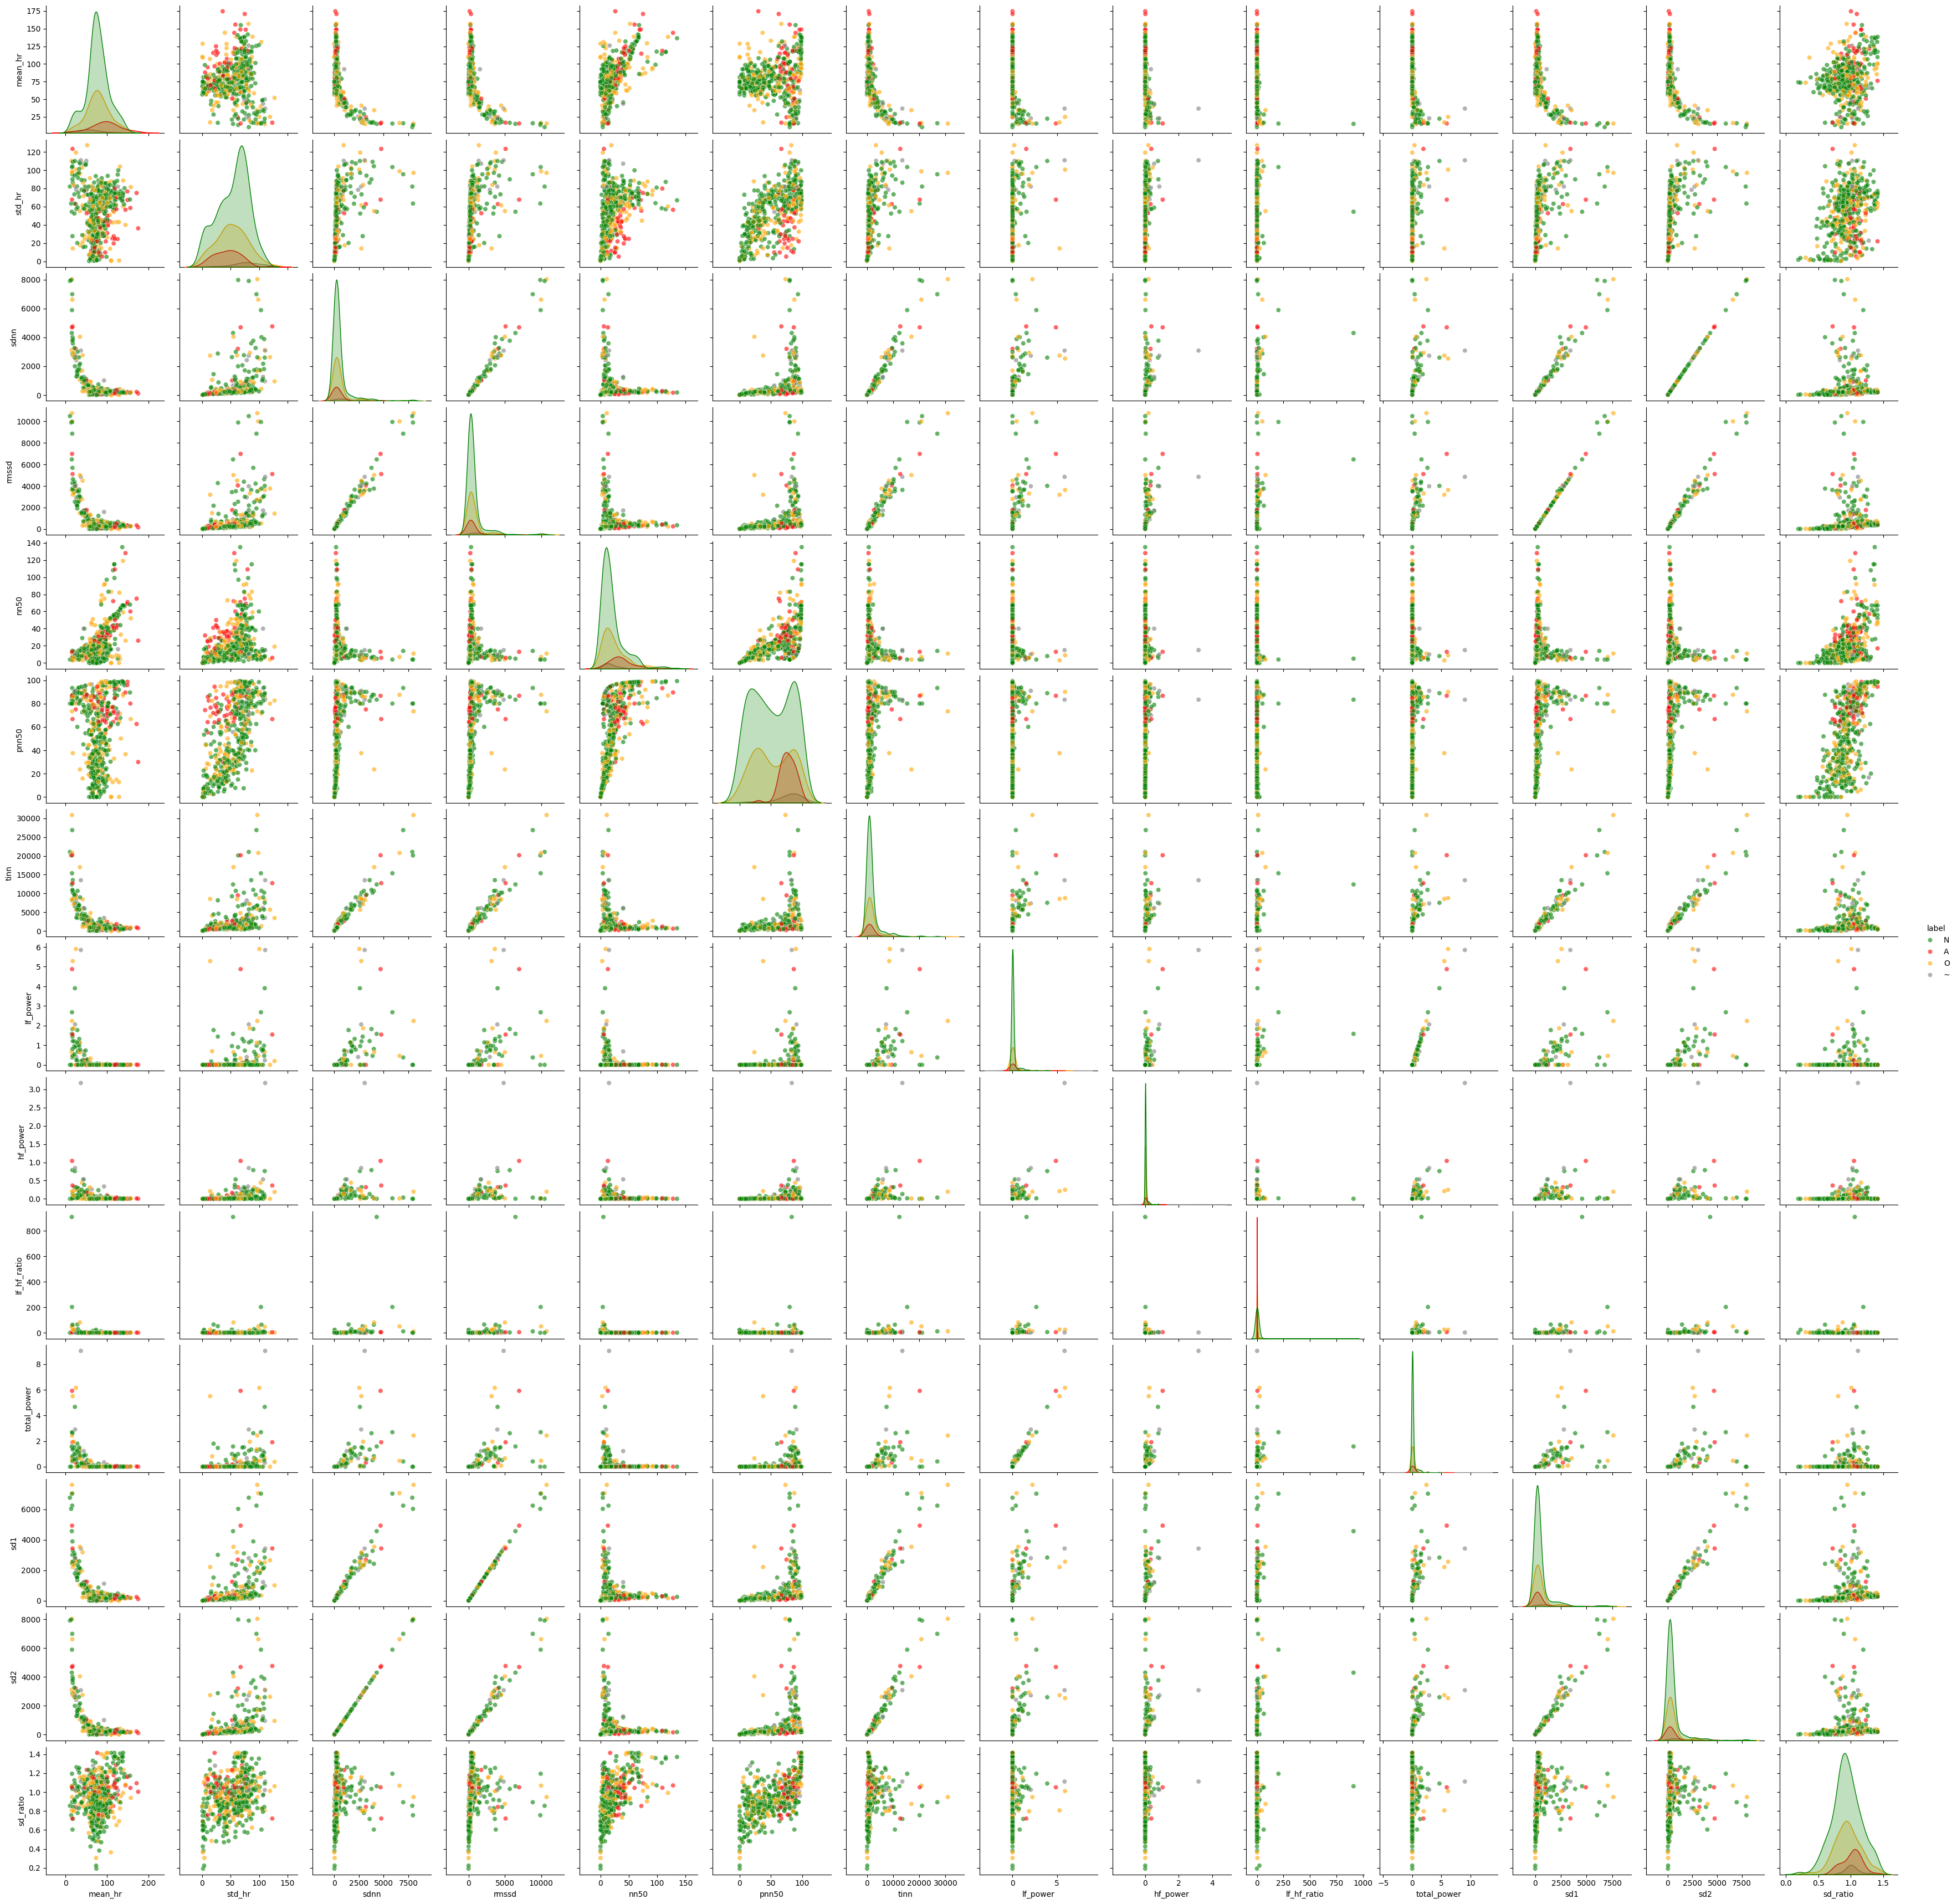

In [6]:


sns.pairplot(hrv_results[:500], hue='label', diag_kind='kde', 
             palette={'N': 'green', 'A': 'red', 'O': 'orange', '~': 'gray'},              
             plot_kws={'alpha': 0.6})
plt.show()

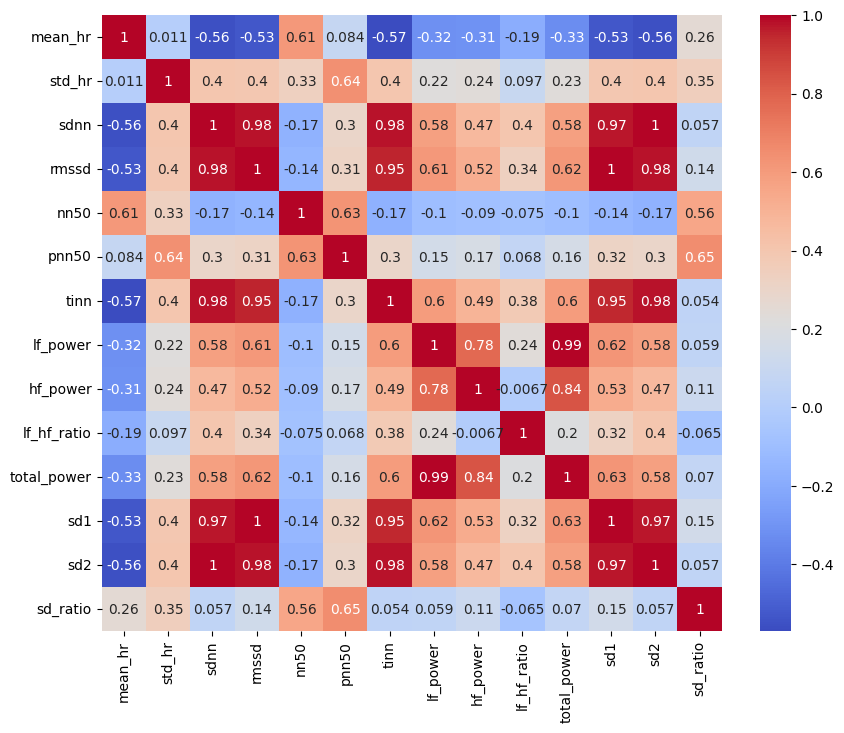

In [7]:
# plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(hrv_results.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.show()

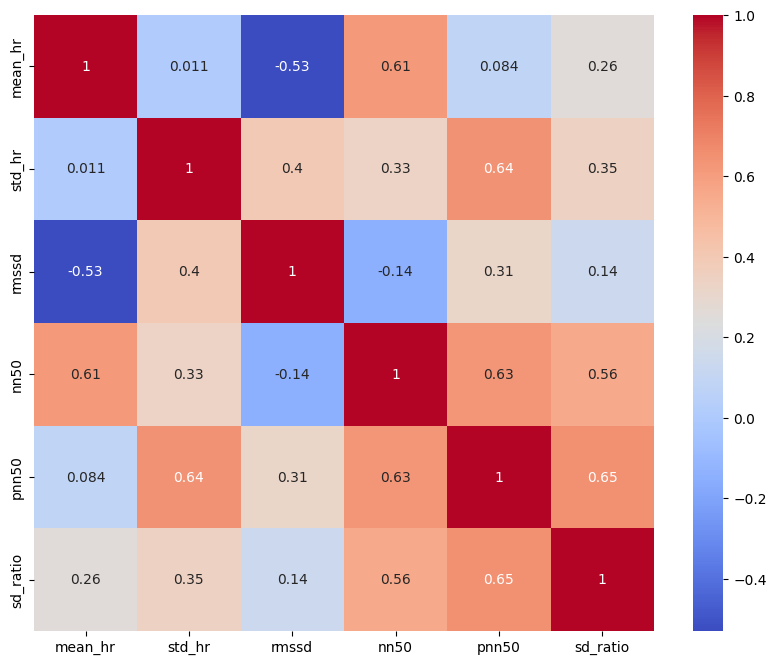

In [31]:
# remove highly correlated features
hrv_results = hrv_results.drop(columns=['sd1', 'sd2', 'total_power', 'tinn', 'sdnn'])
hrv_results = hrv_results.drop(columns=['lf_power', 'hf_power', 'lf_hf_ratio'])
plt.figure(figsize=(10, 8))
sns.heatmap(hrv_results.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.show()

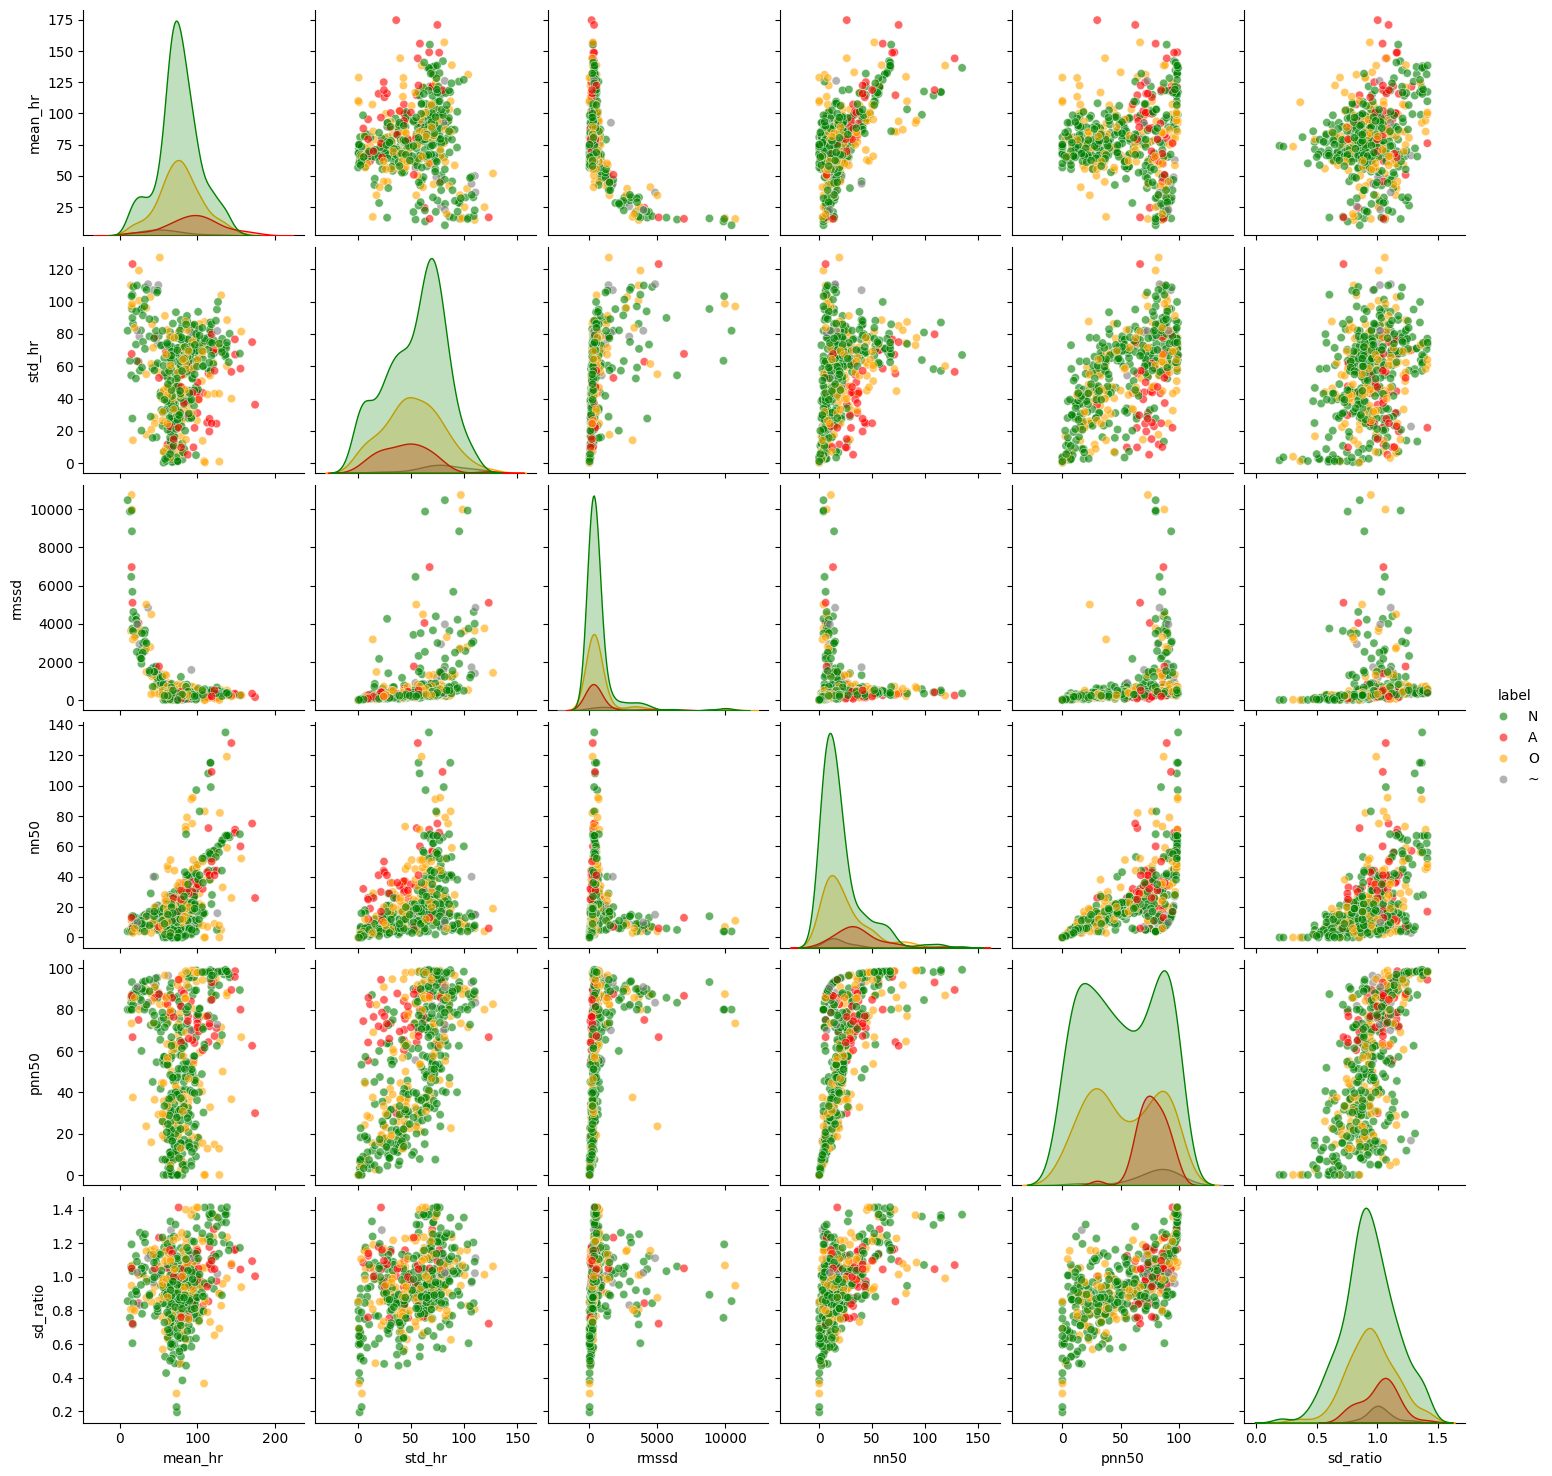

In [40]:
sns.pairplot(hrv_results[:500], hue='label', diag_kind='kde', 
             palette={'N': 'green', 'A': 'red', 'O': 'orange', '~': 'gray'},              
             plot_kws={'alpha': 0.6})
plt.show()

In [33]:

X, y = hrv_results.drop('label', axis=1), hrv_results['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6403, 6)
X_test shape: (1601, 6)
y_train shape: (6403,)
y_test shape: (1601,)


In [34]:
results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Runtime', 'Top Predictor' ])
start_time = time.time()
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_train_score = accuracy_score(y_train, lr.predict(X_train))
lr_test_score = accuracy_score(y_test, lr.predict(X_test))
lr_runtime = time.time() - start_time
top_predictor = X.columns[np.argmax(np.abs(lr.coef_[0]))]
result = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Train Score': [lr_train_score],
    'Test Score': [lr_test_score],
    'Runtime': [lr_runtime],
    'Top Predictor': [top_predictor]
})
print(result)
result = pd.concat([result], ignore_index=True)


                 Model  Train Score  Test Score   Runtime Top Predictor
0  Logistic Regression     0.591598    0.582761  0.069226        std_hr


/Users/mlmnl/Documents/GitHub/artificially-intelligent/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
start_time = time.time()
feature_names = X.columns
# Create a logistic regression model L2
logreg2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
# Fit the model
logreg2.fit(X_train, y_train)
# Predict the target variable
y_pred2 = logreg2.predict(X_test)
# Calculate the accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
# Calculate the runtime
runtime2 = time.time() - start_time
# Get the top predictor
top_predictor2 = feature_names[np.argmax(np.abs(logreg2.coef_))]
# Append the results
result2 = pd.DataFrame({
    'Model': ['Logistic Regression L2'],
    'Train Accuracy': [logreg2.score(X_train, y_train)],
    'Test Accuracy': [accuracy2],
    'Runtime': [runtime2],
    'Top Predictor': [top_predictor2]
})
print(result2)
results = pd.concat([results, result2], ignore_index=True)

                    Model  Train Accuracy  Test Accuracy   Runtime  \
0  Logistic Regression L2        0.606591       0.594004  0.077815   

  Top Predictor  
0      sd_ratio  


/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_69066/1223591269.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result2], ignore_index=True)


In [36]:
from sklearn.calibration import LinearSVC


start_time = time.time()
# Create a linear SVM model
svm = LinearSVC(random_state=42)
# Fit the model
svm.fit(X_train, y_train)
# Predict the target variable
y_pred_svm = svm.predict(X_test)
# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
# Calculate the runtime
runtime_svm = time.time() - start_time
# Get the top predictor
top_predictor_svm = feature_names[np.argmax(np.abs(svm.coef_))]
# Append the results
result_svm = pd.DataFrame({
    'Model': ['Linear SVM'],
    'Train Accuracy': [svm.score(X_train, y_train)],
    'Test Accuracy': [accuracy_svm],
    'Runtime': [runtime_svm],
    'Top Predictor': [top_predictor_svm]
})
print(result_svm)
results = pd.concat([results, result_svm], ignore_index=True)

        Model  Train Accuracy  Test Accuracy   Runtime Top Predictor
0  Linear SVM        0.601124       0.592755  0.061833      sd_ratio


In [37]:
# Create a random forest model
rf = RandomForestClassifier(random_state=42)
# Fit the model
rf.fit(X_train, y_train)
# Predict the target variable
y_pred_rf = rf.predict(X_test)
# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Calculate the runtime
runtime_rf = time.time() - start_time
# Get the top predictor
top_predictor_rf = feature_names[np.argmax(rf.feature_importances_)]
# Append the results
result_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'Train Accuracy': [rf.score(X_train, y_train)],
    'Test Accuracy': [accuracy_rf],
    'Runtime': [runtime_rf],
    'Top Predictor': [top_predictor_rf]
})
print(result_rf)
results = pd.concat([results, result_rf], ignore_index=True)

           Model  Train Accuracy  Test Accuracy   Runtime Top Predictor
0  Random Forest             1.0       0.678326  4.096693       mean_hr


In [38]:
# Create a gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
# Fit the model
gb.fit(X_train, y_train)
# Predict the target variable
y_pred_gb = gb.predict(X_test)
# Calculate the accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
# Calculate the runtime
runtime_gb = time.time() - start_time
# Get the top predictor
top_predictor_gb = feature_names[np.argmax(gb.feature_importances_)]
# Append the results
result_gb = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Train Accuracy': [gb.score(X_train, y_train)],
    'Test Accuracy': [accuracy_gb],
    'Runtime': [runtime_gb],
    'Top Predictor': [top_predictor_gb]
})
print(result_gb)
results = pd.concat([results, result_gb], ignore_index=True)

               Model  Train Accuracy  Test Accuracy   Runtime Top Predictor
0  Gradient Boosting        0.734031       0.671455  9.564435       mean_hr


In [39]:
# Display all the results as a table
display(results)

Model  Train Accuracy  Test Accuracy   Runtime  \
0  Logistic Regression L2        0.606591       0.594004  0.077815   
1              Linear SVM        0.601124       0.592755  0.061833   
2           Random Forest        1.000000       0.678326  4.096693   
3       Gradient Boosting        0.734031       0.671455  9.564435   

  Top Predictor  
0      sd_ratio  
1      sd_ratio  
2       mean_hr  
3       mean_hr

### Let's do some parameter  hypertuning

In [24]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

ft_results = pd.DataFrame(columns=['Model', 'Hyperparameter', 'Train Accuracy', 'Test Accuracy', 'Runtime'])# # A4-1 Find the best hyperparameters for the 3 models

In [25]:
start_time = time.time()
# Function to optimize Logistic Regression L2
def optimize_logreg_l2(C):
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    return accuracy

# Create a BayesianOptimization object

def find_hyperparameter_logreg(X_train, y_train, X_test, y_test): 
    logreg_bo = BayesianOptimization(
        optimize_logreg_l2,
        {'C': (0.001, 10)}
    )

    # Perform the optimization
    logreg_bo.maximize()

    # Get the best hyperparameters
    params = logreg_bo.max['params']
    C = params['C']
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    # Append the results
    result = pd.DataFrame({
        'Model': ['Logistic Regression L2'],
        'Hyperparameter': [f'C={C}'],
        'Train Accuracy': [logreg.score(X_train, y_train)],
        'Test Accuracy': [accuracy],
        'Runtime': [runtime]
    })

    return result


result = find_hyperparameter_logreg(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([result], ignore_index=True)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.5946    | 3.557     |
| 2         | 0.5953    | 4.336     |
| 3         | 0.5965    | 4.37      |
| 4         | 0.5934    | 2.18      |
| 5         | 0.5965    | 7.633     |
| 6         | 0.594     | 7.633     |
| 7         | 0.5946    | 6.047     |
| 8         | 0.5946    | 5.714     |
| 9         | 0.5946    | 4.336     |
| 10        | 0.5946    | 4.336     |
| 11        | 0.5934    | 3.602     |
| 12        | 0.5959    | 7.633     |
| 13        | 0.5959    | 4.37      |
| 14        | 0.5953    | 0.358     |
| 15        | 0.5959    | 9.121     |
| 16        | 0.5959    | 4.37      |
| 17        | 0.5953    | 4.37      |
| 18        | 0.5965    | 5.744     |
| 19        | 0.594     | 5.744     |
| 20        | 0.5934    | 9.121     |
| 21        | 0.5959    | 0.3578    |
| 22        | 0.5946    | 9.121     |
| 23        | 0.594     | 5.744     |
| 24        | 0.5934    | 4.369     |
| 25        

In [26]:
start_time=time.time()

# Find the best hyperparameters for random forest
def optimize_random_forest(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

def find_hyperparameter_rf(X_train, y_train, X_test, y_test):
    pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 10)}
    optimizer = BayesianOptimization(
        f=optimize_random_forest,
        pbounds=pbounds,
        random_state=1,
    )
    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Random Forest',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    rf = RandomForestClassifier(**best_params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    train_accuracy = rf.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Random Forest'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we print the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(rf.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_rf(X_train, y_train, X_test, y_test)
ft_results = pd.concat([ft_results, result], ignore_index=True)
print(result)


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.6494    | 4.753     | 74.83     |
| 2         | 0.5908    | 1.001     | 37.21     |
| 3         | 0.5922    | 2.321     | 18.31     |
| 4         | 0.5918    | 2.676     | 41.1      |
| 5         | 0.6483    | 4.571     | 58.49     |
| 6         | 0.6819    | 9.949     | 98.93     |
| 7         | 0.5908    | 1.091     | 99.35     |
| 8         | 0.6816    | 9.864     | 95.22     |
| 9         | 0.6812    | 9.927     | 85.63     |
| 10        | 0.6809    | 9.888     | 67.2      |
| 11        | 0.6814    | 9.978     | 77.37     |
| 12        | 0.6812    | 9.974     | 59.49     |
| 13        | 0.6805    | 9.988     | 53.34     |
| 14        | 0.6798    | 9.974     | 72.32     |
| 15        | 0.6814    | 9.913     | 90.49     |
| 16        | 0.6811    | 9.919     | 82.04     |
| 17        | 0.6809    | 9.914     | 56.42     |
| 18        | 0.6806    | 9.995     | 64.42     |


In [27]:
# Find the best hyperparameters for gradient boosting
start_time = time.time()

def optimize_gradient_boosting(n_estimators, max_depth, learning_rate):
    model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))


def find_hyperparameter_gb(X_train, y_train, X_test, y_test):
    
    pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 10), 'learning_rate': (0.01, 0.1)}
    optimizer = BayesianOptimization(
        f=optimize_gradient_boosting,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Gradient Boosting',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    gb = GradientBoostingClassifier(**best_params, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    train_accuracy = gb.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Gradient Boosting'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we can get the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(gb.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_gb(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([ft_results, result], ignore_index=True)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6492    | 0.04753   | 7.483     | 10.01     |
| 2         | 0.608     | 0.03721   | 2.321     | 18.31     |
| 3         | 0.6592    | 0.02676   | 4.11      | 45.71     |
| 4         | 0.673     | 0.05849   | 4.773     | 71.67     |
| 5         | 0.62      | 0.0284    | 8.903     | 12.46     |
| 6         | 0.6714    | 0.0871    | 4.767     | 71.51     |
| 7         | 0.6698    | 0.09918   | 6.727     | 74.95     |
| 8         | 0.5908    | 0.03274   | 1.871     | 75.03     |
| 9         | 0.6727    | 0.02132   | 7.091     | 72.38     |
| 10        | 0.6683    | 0.04173   | 9.931     | 74.93     |
| 11        | 0.6669    | 0.04787   | 9.109     | 78.7      |
| 12        | 0.6684    | 0.04821   | 9.66      | 83.29     |
| 13        | 0.6734    | 0.09057   | 5.793     | 82.94     |
| 14        | 0.6772    | 0.02702   | 6.654     | 86.69     |
| 15    

In [28]:
pd.set_option('display.max_colwidth', None)  
display(ft_results)

Model  \
0  Logistic Regression L2   
1           Random Forest   
2       Gradient Boosting   

                                                                Hyperparameter  \
0                                                          C=4.369842194336384   
1                                         {'max_depth': 9, 'n_estimators': 92}   
2  {'learning_rate': 0.027022248091647102, 'max_depth': 6, 'n_estimators': 86}   

   Train Accuracy  Test Accuracy     Runtime  
0        0.606747       0.596502    3.188087  
1        0.772138       0.677701   57.238872  
2        0.781509       0.679575  750.429347